# import dependencies

In [ ]:
# Last Of All
# Generals
from sklearn.model_selection import train_test_split
from IPython.display  import clear_output 
from typing import Any, Literal
from numpy import floating
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
from pandas.core.series import Series
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 


# Gym (Environmet)
import gymnasium as gym
from gymnasium import spaces


# Modeling (PyTorch)
import torch.nn.functional as F
import torch
Tensor = torch.Tensor
import torch.nn as nn
from torch.optim import Adam, RMSprop
from torch.distributions import Categorical


In [116]:
try: 
	import backtrader as bt
	# import
	print('`backtrader` import Succesfully')
except ModuleNotFoundError:
	pass
	%pip install backtrader 
	clear_output ()
	import backtrader as bt
	print('Module`backtrader` NotFound Error. So installed')


`backtrader` import Succesfully


In [117]:
try: 
	import openpyxl
	print('`openpyxl` import Succesfully')
except ModuleNotFoundError:
	pass
	%pip install openpyxl 
	clear_output ()
	import openpyxl
	print('Module `openpyxl` NotFound Error. So installed')

`openpyxl` import Succesfully


In [118]:
# %matplotlib inline

In [119]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

# data Import

In [ ]:
kaggle = True

if kaggle:
	path_m5_xau : str = r"/kaggle/input/price-values/price-values/XAUUSDM5.csv"
	path_m15_xau: str = r"/kaggle/input/price-values/price-values/XAUUSDM15.csv"
	path_daily_xau: str = r"/kaggle/input/price-values/price-values/XAUUSDDaily.csv"

	path_m5_eur: str = r"/kaggle/input/price-values/price-values/EURUSDM5.csv"
	path_m15_eur: str = r"/kaggle/input/price-values/price-values/EURUSDM15.csv"
	path_daily_eur: str = r"/kaggle/input/price-values/price-values/EURUSDDaily.csv"

else:
	path_m5_xau : str = r"price-values/XAUUSDM5.csv"
	path_m15_xau: str = r"price-values/XAUUSDM15.csv"
	path_daily_xau: str = r"price-values/XAUUSDDaily.csv"

	path_m5_eur: str = r"price-values/EURUSDM5.csv"
	path_m15_eur: str = r"price-values/EURUSDM15.csv"
	path_daily_eur: str = r"price-values/EURUSDDaily.csv"


In [121]:
Round = 4
rsi_len = 14
movAvgLen = 5
ma_1 = 10
ma_2 = 20


window_size = 5


## small DataFrame

In [122]:
df_small = pd.read_csv(path_m5_eur , 
				   encoding = 'utf-16', 
				   names =  ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', '0'] )

df_small['Date'] = pd.to_datetime(df_small['Date'])
df_small.set_index('Date', drop=True, inplace = True)
df_small.drop('0', axis=1,  inplace = True)

print(df_small.shape)
df_small.head()

(100000, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2024-03-22 05:15:00,1.08368,1.08381,1.08368,1.08376,86
2024-03-22 05:20:00,1.08376,1.08394,1.08376,1.08379,79
2024-03-22 05:25:00,1.08379,1.08392,1.08376,1.08380,132
2024-03-22 05:30:00,1.08380,1.08384,1.08358,1.08363,151
2024-03-22 05:35:00,1.08363,1.08396,1.08363,1.08393,122


## Big DataFrame

In [123]:
df_big = pd.read_csv(path_daily_eur , 
				   encoding = 'utf-16', 
				   names =  ['Date', 'Open D', 'High D', 'Low D', 'Close D', 'Volume D', '0'] )

df_big['Date'] = pd.to_datetime(df_big['Date'])
df_big.set_index('Date', drop=True, inplace = True)
df_big.drop('0', axis=1,  inplace = True)

print(df_big.shape)
df_big.head()

(1131, 5)


,Open D,High D,Low D,Close D,Volume D
Date,,,,,
2021-03-29,1.17886,1.17937,1.17608,1.17642,59703
2021-03-30,1.17640,1.17736,1.17114,1.17169,56334
2021-03-31,1.17170,1.17598,1.17041,1.17298,60218
2021-04-01,1.17298,1.17799,1.17124,1.17759,54081
2021-04-02,1.17760,1.17864,1.17488,1.17608,25975


## Total DataFrame

In [124]:
df_total = pd.concat([df_small, df_big], axis=1)
df_total.fillna(0, inplace = True)
print(df_total.shape)
df_total.tail()

(100781, 10)


,Open,High,Low,Close,Volume,Open D,High D,Low D,Close D,Volume D
Date,,,,,,,,,,
2025-07-28 01:50:00,1.17529,1.17547,1.17528,1.17547,63.0,0.00000,0.00000,0.00000,0.00000,0.0
2025-07-28 01:55:00,1.17547,1.17569,1.17541,1.17545,96.0,0.00000,0.00000,0.00000,0.00000,0.0
2025-07-28 02:00:00,1.17546,1.17575,1.17540,1.17565,98.0,0.00000,0.00000,0.00000,0.00000,0.0
2025-07-29 00:00:00,0.00000,0.00000,0.00000,0.00000,0.0,1.15854,1.15987,1.15185,1.15442,56173.0
2025-07-30 00:00:00,0.00000,0.00000,0.00000,0.00000,0.0,1.15421,1.15497,1.15420,1.15487,809.0


# Needed Functions

In [125]:

def calculate_RSI(data: Series , time_window : int = 14) -> Series:
		delta: Series[type[float]] = data.diff() # type: ignore

		up, down = delta.copy(), delta.copy()
		up[up < 0] = 0 # type: ignore
		down[down > 0] = 0 # type: ignore

		roll_up: Series[float] = up.rolling(time_window).mean()
		roll_down: Series[float] = down.abs().rolling(time_window).mean()

		RS: Series[float] = roll_up / roll_down
		RSI: Series[float] = 100.0 - (100.0 / (1.0 + RS))

		return RSI.round(Round)



def macd(data, fast, slow):
	if isinstance(data, np.ndarray):
		ma1 =  np.convolve(data, np.ones(fast)/fast, mode='valid')
		ma2 =  np.convolve(data, np.ones(slow)/slow, mode='valid')
		return ma2 - ma1
	if isinstance(data, pd.Series):
		ma1 =  data.rolling(fast, min_periods=1).mean()
		ma2 =  data.rolling(slow, min_periods=1).mean()
		return ma2 - ma1



def clc_mean(series : Series , window: int) :
		rolling_mean = series.rolling(window=window).mean().round(Round)
		return  rolling_mean

def moving_avg_std(series : Series , window : int)  -> Series:
	"""Calculate the moving average and standard deviation of a pandas series, and then divide the two"""
	rolling_mean = series.rolling(window=window).mean().round(Round)
	rolling_std = series.rolling(window=window).std().round(Round)
	return rolling_mean - rolling_std



In [126]:
def creat_data(df: pd.DataFrame):
	df['MovAvg'] = df['Close'].rolling(movAvgLen).mean()

	df['diff']  =  (df['Close'] - df['MovAvg']).round(Round) 
	df['cadle-type']  = (df['Close'] - df['Open']).round(Round)
	df['change']  =  df['Open'] - df['MovAvg'] 
	df['macd'] = macd(df['Close'], movAvgLen, movAvgLen*2 )
	df['percent']  =  (df['Close'] - df['Open']) / df['Close']  * 100

	df['rsi']  = calculate_RSI( df['Open'] , rsi_len ) / 100

	df['Pivot'] = (df['High'] + df['Low'] + df['Close']) / 3
	# First support and resistance
	df['R1'] = (2 * df['Pivot']) - df['Low']
	df['S1'] = (2 * df['Pivot']) - df['High']

	try:
		df['MovAvg D'] = df['Close D'].rolling(movAvgLen).mean()
		df['Pivot D'] = (df['High D'] + df['Low D'] + df['Close D']) / 3
		df['rsi D']  = calculate_RSI( df['Open D'] , rsi_len ) / 100
		df['R1 D'] = (2 * df['Pivot D']) - df['Low D']
		df['S1 D'] = (2 * df['Pivot D']) - df['High D']

	except KeyError as e:
		pass

	df = df.dropna(axis=0)

	return df

In [127]:
df_total.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Open D', 'High D', 'Low D',
       'Close D', 'Volume D'],
      dtype='object')

# create Data

In [128]:
df_total = df_total[
	['Open', 'High', 'Low', 'Close', 'Volume', 
	 'Open D', 'High D', 'Low D', 'Close D', 'Volume D']
	 							]
df = creat_data(df_total)
df['Volume'] = df['Volume'].astype(np.float64)
df.head(10)

,Open,High,Low,Close,Volume,Open D,High D,Low D,Close D,Volume D,...,percent,rsi,Pivot,R1,S1,MovAvg D,Pivot D,rsi D,R1 D,S1 D
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-22 05:15:00,1.08368,1.08381,1.08368,1.08376,86.0,0.0,0.0,0.0,0.0,0.0,...,0.007382,1.000000,1.083750,1.083820,1.083690,0.869016,0.0,0.015532,0.0,0.0
2024-03-22 05:20:00,1.08376,1.08394,1.08376,1.08379,79.0,0.0,0.0,0.0,0.0,0.0,...,0.002768,1.000000,1.083830,1.083900,1.083720,0.651726,0.0,0.015426,0.0,0.0
2024-03-22 05:25:00,1.08379,1.08392,1.08376,1.08380,132.0,0.0,0.0,0.0,0.0,0.0,...,0.000923,1.000000,1.083827,1.083893,1.083733,0.433316,0.0,0.011765,0.0,0.0
2024-03-22 05:30:00,1.08380,1.08384,1.08358,1.08363,151.0,0.0,0.0,0.0,0.0,0.0,...,-0.015688,1.000000,1.083683,1.083787,1.083527,0.216124,0.0,0.007344,0.0,0.0
2024-03-22 05:35:00,1.08363,1.08396,1.08363,1.08393,122.0,0.0,0.0,0.0,0.0,0.0,...,0.027677,0.999843,1.083840,1.084050,1.083720,0.000000,0.0,0.007350,0.0,0.0
2024-03-22 05:40:00,1.08394,1.08396,1.08385,1.08390,77.0,0.0,0.0,0.0,0.0,0.0,...,-0.003690,0.999843,1.083903,1.083957,1.083847,0.000000,0.0,0.007359,0.0,0.0
2024-03-22 05:45:00,1.08390,1.08402,1.08387,1.08395,102.0,0.0,0.0,0.0,0.0,0.0,...,0.004613,0.999806,1.083947,1.084023,1.083873,0.000000,0.0,0.007252,0.0,0.0
2024-03-22 05:50:00,1.08395,1.08397,1.08378,1.08378,81.0,0.0,0.0,0.0,0.0,0.0,...,-0.015686,0.999806,1.083843,1.083907,1.083717,0.000000,0.0,0.005332,0.0,0.0
2024-03-22 05:55:00,1.08378,1.08387,1.08376,1.08380,120.0,0.0,0.0,0.0,0.0,0.0,...,0.001845,0.999650,1.083810,1.083860,1.083750,0.000000,0.0,0.005362,0.0,0.0


## Choosing Features

In [129]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=.5)
selector.fit(df)
df_selected = df[df.columns[~selector.get_support(indices=True)]]
df_selected.head()

,MovAvg D,percent
Date,,
2024-03-22 05:15:00,0.869016,0.007382
2024-03-22 05:20:00,0.651726,0.002768
2024-03-22 05:25:00,0.433316,0.000923
2024-03-22 05:30:00,0.216124,-0.015688
2024-03-22 05:35:00,0.000000,0.027677


In [130]:
df_selected.columns

Index(['MovAvg D', 'percent'], dtype='object')

## Final Features

In [131]:
data = df[
				[	'Open', 'High', 'Low' , 'Close', 'Volume',
					# 'macd',
					'Pivot D', 
					#   "R1 D", 'S1 D', 
					# 'MovAvg D'
				]
					]
data.head(10)

,Open,High,Low,Close,Volume,Pivot D
Date,,,,,,
2024-03-22 05:15:00,1.08368,1.08381,1.08368,1.08376,86.0,0.0
2024-03-22 05:20:00,1.08376,1.08394,1.08376,1.08379,79.0,0.0
2024-03-22 05:25:00,1.08379,1.08392,1.08376,1.08380,132.0,0.0
2024-03-22 05:30:00,1.08380,1.08384,1.08358,1.08363,151.0,0.0
2024-03-22 05:35:00,1.08363,1.08396,1.08363,1.08393,122.0,0.0
2024-03-22 05:40:00,1.08394,1.08396,1.08385,1.08390,77.0,0.0
2024-03-22 05:45:00,1.08390,1.08402,1.08387,1.08395,102.0,0.0
2024-03-22 05:50:00,1.08395,1.08397,1.08378,1.08378,81.0,0.0
2024-03-22 05:55:00,1.08378,1.08387,1.08376,1.08380,120.0,0.0


# Create Envirnment

In [132]:

class MarketEnv(gym.Env):
	metadata = {"render_modes": ["human"], "render_fps": 4}

	def __init__(self, 
				 df: pd.DataFrame, 
				 win_size: int, 
				 sharpe_weight : float = .4,
				 shapre_compression : int = 5,
				 size : float = 0.01 ,
				 threshold = 0.001,
				 commission : float = 1e-2,
				 portfolio : float = 100,
				 risk_free_rate : float = 1e-2):
		super().__init__()
		self.df = df.reset_index(drop=True).astype(np.float32)
		self.win_size = win_size
		self.num_features = df.shape[1]
		self.current_step = self.win_size
		self.max_steps = len(df) - win_size - 1
		self.step_count : int = 0
		self.current_position : int = 0
		self.reward : float = 0.
		self.risk_free_rate: float = risk_free_rate
		self.trade_record: list[list[ float]] = list()
		self.pnl : float = 0.
		self.sharpe_reward : float = 0.
		self.portfolio_Start = portfolio
		self.portfolio = portfolio
		self.size = size
		self.commission = commission
		self.sharpe_weight = sharpe_weight
		self.shapre_compression = shapre_compression
		self.threshold = threshold 
		self.action_space = spaces.Discrete(3, start=-1) # Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
		self.observation_space = spaces.Box(
			low=-np.inf,
			high=np.inf,
			shape=(win_size, self.num_features),
			dtype=np.float32
		)
		self.state : np.ndarray

	def reset(self, *, seed=None, options=None):
		super().reset(seed=seed)
		self.current_step = self.win_size
		self.step_count = 0
		self.current_position = 0
		self.state = self._get_observation()
		self.trade_record.clear()
		self.pnl : float = 0.
		self.sharpe_reward : float = 0.
		self.portfolio = self.portfolio_Start
		return self.state, {}


	def _get_observation(self):
		window = self.df.iloc[max(0, self.current_step - self.win_size): self.current_step].to_numpy()
		window_tensor = torch.tensor(window, dtype=torch.float32)

		# اگر ردیف‌ها کمتر از win_size بودن، باید zero-padding کنیم
		if window_tensor.shape[0] < self.win_size:
			pad_rows = self.win_size - window_tensor.shape[0]
			# pad last dim with 0s: (left, right, top, bottom)
			padding = (0, 0, pad_rows, 0)  # پد در بالا
			window_tensor = F.pad(window_tensor, padding, "constant", 0)

		return window_tensor.numpy()


	def _calc_pnl(self, prices: float , action : int ) -> float:
		
		transaction_cost = self.commission
		# transaction_cost = (prices  *  self.size ) * self.commission
		

		return (prices * action *  self.size ) - transaction_cost

	def _calc_shapre(self):
		if len(self.trade_record) < 2:
			return 0.0  # جلوگیری از تقسیم بر صفر
		# print("trade_record\n", self.trade_record[-self.shapre_compression:])
		excess_returns: np.ndarray = np.array(np.array(self.trade_record)[-self.shapre_compression:, 1]) - self.risk_free_rate
		mean_excess_return: floating[Any] = np.mean(excess_returns)
		std_excess_return: floating[Any] = np.std(excess_returns)
		
		if std_excess_return == 0:
			return 0.0
		
		sharpe: floating[Any] = mean_excess_return / std_excess_return
		return sharpe * np.sum(excess_returns)  

	def _calc_rew(self,changes) :
		if changes >= self.threshold:
			return 1
		else:
			return 0
		
		...
	def step(self, action : int,):

		# action += 1
		match action:
			case  0:
				real_action = 1  # Buy
			case 1:
				real_action = -1 # Sell
			case 2:
				real_action = 0  # Hold

 
		self.current_step += 1
		self.step_count += 1
		self.current_position = action # type: ignore
		terminated: bool = False
		truncated: bool = self.step_count >= self.max_steps
		# print(f'state 0\n {self.state}')
		self.state = self._get_observation()
		# print(f'state 1\n {self.state}')

		# State:
		# O: 0 | H: 1 | L: 2 | C: 3 | V: 4 |         
		chnages = self.state[:,0][0] - self.state[:,0][-1]
		# print(f"chnages\n {chnages}")
		self.pnl = self._calc_pnl(chnages , real_action )
		change_rew = 1 #self._calc_rew(self.pnl)
		self.trade_record.append([ action ,self.pnl])
		
		self.sharpe_reward = self._calc_shapre()

		self.reward = ((
			(1 - self.sharpe_weight) * self.pnl) +\
				 (self.sharpe_weight * self.sharpe_reward)
				 ) * change_rew
		
		self.portfolio += self.pnl if not self.reward == 0 else 0

		info = {}
		return self.state, self.reward , terminated, truncated, info

	def render(self, mode="human"):
		print(f"Step: {self.step_count}, Reward: {self.reward:.4f}")


# Make Model

In [ ]:

class PolicyNetwork(nn.Module):
	def __init__(self, win_size , n_feature):
		super().__init__()

		self.norm_all = nn.LayerNorm(n_feature)
		
		self.i_know = nn.LSTM(input_size=n_feature, 
						hidden_size=n_feature,
						  num_layers= 128,
						  batch_first=True,
						  bidirectional= False
						  )
		

		
		self.i_see = nn.Sequential(
			nn.Conv1d(in_channels=win_size, out_channels=win_size, kernel_size=7, padding='same'),
			nn.BatchNorm1d(win_size),
			nn.LeakyReLU(),
			nn.Conv1d(in_channels=win_size, out_channels=win_size, kernel_size=5, padding='same'),
			nn.BatchNorm1d(win_size),
			nn.LeakyReLU(),
			nn.Conv1d(in_channels=win_size, out_channels=win_size, kernel_size=3, padding='same'),
			nn.BatchNorm1d(win_size),
			nn.LeakyReLU()
			)

		self.i_decide = nn.Sequential(
			nn.Flatten(),
			nn.Linear(win_size * n_feature *2, 1024), 
			nn.Dropout(.5),
			nn.LeakyReLU(),
			nn.Linear(1024, 512), 
			nn.LeakyReLU(),
			nn.Linear(512, 128), 
			# -------------------------------------
			nn.Linear(128, 812), # fc1
			nn.Dropout(.5),
			nn.LeakyReLU(),
			nn.Linear(812, 128), # fc2
			nn.LeakyReLU(),
			nn.Linear(128, 3), # out
	
		)


	def forward(self, X: Tensor) -> Tensor:
		# print(X.shape)
		x : Tensor = self.norm_all(X).unsqueeze(0)

		iknow : Tensor
		iknow ,_ = self.i_know(x)

		isee : Tensor = self.i_see(x)
		# print(isee.shape, iknow.shape)
		# whathpend =  F.sigmoid(isee + iknow)
		whathpend =  torch.cat([iknow, isee], dim=1) #isee + iknow.tanh()
		# print(torch.cat([iknow, isee], dim=1).shape)
		# print(torch.cat([iknow, isee], dim=1).flatten().shape)
		out = self.i_decide(whathpend)

		return out




# تبدیل observation به بردار 1D برای ورودی شبکه
def preprocess_obs(obs : np.ndarray | Tensor) -> torch.Tensor:
	return torch.tensor(obs, dtype=torch.float32)


In [134]:
assert not data.isnull().any().any(), "NaN exists in dataframe!"

data.describe()

,Open,High,Low,Close,Volume,Pivot D
count,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000
mean,1.090434,1.090576,1.090292,1.090455,50.022095,0.072708
std,0.037342,0.037351,0.037328,0.037344,63.865445,0.272247
min,1.023100,1.024040,1.022480,1.023340,4.000000,0.000000
25%,1.066958,1.067080,1.066877,1.066950,20.000000,0.000000
50%,1.084610,1.084780,1.084500,1.084620,34.000000,0.000000
75%,1.113068,1.113125,1.112907,1.113063,56.000000,0.000000
max,1.180470,1.180560,1.180440,1.180520,2410.000000,1.179843


# Create Agent

In [135]:

class SimpleRLAgent:
	def __init__(self, win_size, num_features ,action_dim):
		self.policy = PolicyNetwork (win_size=win_size, n_feature=num_features )
		self.policy.to(device)
		self.optimizer = RMSprop(self.policy.parameters(), lr=0.01)
		self.buffer = []  # Stores (log_prob, reward) pairs
	
	def select_action(self, state):
		state = torch.FloatTensor(state).to(device)#.unsqueeze(0)
		logits = self.policy(state)
		probs: Tensor = F.softmax(logits, dim=-1)  # Convert logits to probabilities
		
		m = Categorical(probs)
		action = m.sample().squeeze(0)

		log_prob: Tensor = m.log_prob(action) 
		
		return action, log_prob
	
	def update(self):
		if not self.buffer:
			return
		
		# Extract stored (log_prob, reward) pairs
		log_probs, rewards = zip(*self.buffer)
		log_probs = torch.stack(log_probs).to(device)
		rewards = torch.FloatTensor(rewards).to(device)
		
		# Normalize rewards (reduces variance)
		rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-8)
		
		# Policy gradient loss: -log_prob * reward (maximize reward)
		loss = (-log_probs * rewards).mean()
		
		self.optimizer.zero_grad()
		loss.backward()
		self.optimizer.step()
		
		self.buffer = []  # Clear buffer after update
		return loss.item()

In [136]:
torch.autograd.set_detect_anomaly(True)


In [137]:
data.shape

(5250, 6)

# Trainig Procces

In [138]:


env = MarketEnv(df=data, 
				win_size=window_size,
				risk_free_rate = 1e-1 ,
				sharpe_weight = .5 ,
				shapre_compression= 5,
				size= .1, # bigger, better for EUR
				commission = 7,
				threshold = 0.001

			   )
obs, _ = env.reset()



agent = SimpleRLAgent(win_size=window_size, 
					  num_features=env.num_features, 
					  action_dim=3)  # 3 discrete actions


num_episodes = 10
max_steps = 1_000
reward_to_episodes = list()
gain_over_episode = list()

for episode in range(num_episodes):
	state ,_= env.reset()
	done : bool = False
	episode_reward = 0.
	
	# while not done:
	for step in range(max_steps):
		action, log_prob = agent.select_action(state)
		next_state, reward, terminated, truncated, _ = env.step(action.detach().cpu()) # type: ignore
		agent.buffer.append((log_prob, reward))
		
		state = next_state
		episode_reward += reward
		done: bool = terminated or truncated

		# if done:
	agent.update()  # Update policy at the end of the episode
	gain_over_episode.append(env.portfolio)
	print(f"Episode {episode+1} | Reward {episode_reward:.4f} | Gain {env.portfolio:.4f}")
	reward_to_episodes.append(episode_reward)





Episode 1 | Reward 11365541911.5877 | Gain -6900.0127
Episode 2 | Reward 14202519275.9903 | Gain -6899.9927
Episode 3 | Reward 12283058652.7485 | Gain -6899.9971
Episode 4 | Reward 12273053448.6164 | Gain -6899.9927
Episode 5 | Reward 12421127789.7917 | Gain -6899.9980
Episode 6 | Reward 12232558479.9508 | Gain -6899.9990
Episode 7 | Reward 13181216822.4136 | Gain -6899.9937
Episode 8 | Reward 13734400036.5503 | Gain -6899.9912
Episode 9 | Reward 12717235059.6659 | Gain -6899.9956
Episode 10 | Reward 13269828378.0553 | Gain -6900.0015


In [139]:
params = torch.tensor(0.0)

for name, param in agent.policy.named_parameters():
	params += param.size().numel()
	# print(name, param.size(),)

params

tensor(905567.)

# Evaluate

In [140]:
final_portfolio = env.portfolio
max_drawup = np.max(env.trade_record)
max_drawdown = np.min(env.trade_record)
mean_record = np.mean(env.trade_record)
std_record = np.std(env.trade_record) 
median_record = np.median(env.trade_record)



print(f"""
portfolio   {final_portfolio : .4f}
max gain    {max_drawup  :.4f}
min gain    {max_drawdown  :.4f}
mean gain   {mean_record  :.4f}
std gain   {std_record :.4f}
median gain {median_record  :.4f}
""")


portfolio   -6900.0015
max gain    2.0000
min gain    -7.0013
mean gain   -3.0185
std gain   4.0228
median gain -3.4994



## Reward

In [141]:
sns.lineplot({"reward": reward_to_episodes})
plt.title("total reward for each episode")
plt.xlabel('Episodes')
plt.ylabel("Rewards")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>

## Records of Positions(PnL)

In [142]:
sns.lineplot({"Record": np.array(env.trade_record)[:,1] } )
plt.title("total Record")
plt.xlabel('Position')
plt.ylabel("gain")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>

## Gain Over Each Episodes

In [143]:
sns.lineplot({"gains": gain_over_episode } )
plt.title("total Record")
plt.xlabel('Position')
plt.ylabel("gain")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>

## Ready Eval Data

In [144]:
n_features = env.num_features
n_rows = data.shape[0]
usable_rows = (n_rows // window_size) * window_size
data_trimmed = data.iloc[:usable_rows, :]

data_tensor = torch.tensor(data_trimmed.to_numpy(), dtype=torch.float).reshape(-1, window_size, n_features).to(device)
print(data_tensor.shape)

torch.Size([1050, 5, 6])


In [145]:
print(data_tensor.shape, data.shape)

torch.Size([1050, 5, 6]) (5250, 6)


## Eval Lables

In [146]:

labels = []
with torch.no_grad():
	agent.policy.eval()
	for state in data_tensor:
		probs  = F.softmax(agent.policy(state), dim=-1) # type: ignore
		m = Categorical(probs)
		action = m.sample().squeeze(0).item()
		labels.append(action)

tensor_labels = torch.tensor(labels)


In [147]:
print(f"""
uniques {torch.unique(tensor_labels, return_counts=True)}
labels.shape {tensor_labels.shape} 
data_tensor.shape {data_tensor.shape}
data.shape {data.shape} """)


uniques (tensor([0, 1, 2]), tensor([395, 333, 322]))
labels.shape torch.Size([1050]) 
data_tensor.shape torch.Size([1050, 5, 6])
data.shape (5250, 6) 


## Eval Dataframe Ready 

In [148]:

trade_df = data.copy()
labels_full = [2] * len(trade_df)  # مقدار پیش‌فرض برای همه ردیف‌ها

# تعداد ردیف‌هایی که برای مدل استفاده شدن
usable_rows = (len(df) // window_size) * window_size

for i, label in enumerate(tensor_labels):
	idx = i * window_size
	if idx < len(labels_full):
		labels_full[idx] = label.item()   # type: ignore
		# the rest all `2`

data['signal'] = labels_full


data.head()


,Open,High,Low,Close,Volume,Pivot D,signal
Date,,,,,,,
2024-03-22 05:15:00,1.08368,1.08381,1.08368,1.08376,86.0,0.0,1
2024-03-22 05:20:00,1.08376,1.08394,1.08376,1.08379,79.0,0.0,2
2024-03-22 05:25:00,1.08379,1.08392,1.08376,1.08380,132.0,0.0,2
2024-03-22 05:30:00,1.08380,1.08384,1.08358,1.08363,151.0,0.0,2
2024-03-22 05:35:00,1.08363,1.08396,1.08363,1.08393,122.0,0.0,2


In [149]:
data['shifted'] = data['Close'].shift(5)#.mean()
data['true-diff'] = data['Close'] - data['shifted']

data['true-signal'] = 2  # default
data.loc[data['shifted'] <= data['Close'], 'true-signal'] = 0
data.loc[data['shifted'] >= data['Close'], 'true-signal'] = 1

data.dropna(inplace=True)
fliterd_data = data[['Close', 'shifted', 'true-diff', 'signal', 'true-signal']]

# fliterd_data = fliterd_data[(fliterd_data['true-signal'] == fliterd_data['signal']) ]

fliterd_data.sample(5)

,Close,shifted,true-diff,signal,true-signal
Date,,,,,
2025-07-16 00:35:00,1.15977,1.15975,0.00002,2,0
2024-11-22 00:25:00,1.04751,1.04703,0.00048,2,0
2024-11-21 00:30:00,1.05421,1.05401,0.00020,1,0
2024-07-23 00:45:00,1.08897,1.08868,0.00029,2,0
2024-10-09 00:25:00,1.09778,1.09733,0.00045,2,0


## Classification Report

In [150]:
accuracy = (data['true-signal'] == data['signal']).mean()

from sklearn.metrics import classification_report


report = classification_report(data['true-signal'], data['signal'], target_names = ['Buy', 'Sell', 'Hold'])

print(f"""
accuracy {accuracy:.4%}
report
{report}
""")


accuracy 6.9971%
report
              precision    recall  f1-score   support

         Buy       0.59      0.07      0.13      3145
        Sell       0.40      0.06      0.11      2100
        Hold       0.00      0.00      0.00         0

    accuracy                           0.07      5245
   macro avg       0.33      0.05      0.08      5245
weighted avg       0.52      0.07      0.12      5245




In [151]:
np.unique(data['signal'].to_numpy(), return_counts = True)

(array([0, 1, 2]), array([ 395,  332, 4518]))

In [152]:
# from IPython.display import clear_output 
# %pip install backtrader
# clear_output ()

# Back Testing

## Data for Backtesting

In [153]:
data = data[
				[	'Open', 'High', 'Low' , 'Close', 'Volume',
					# 'macd',
					'Pivot D', 
					#   "R1 D", 'S1 D', 
					# 'MovAvg D'
				]
					]

In [154]:
# 1. Define a custom Pandas feed with signal line
class PandasSignalData(bt.feeds.PandasData):
	lines = ('Pivot',)  
	params = (('Pivot', 5),)  # tell backtrader where to find it (column index or name)


In [158]:
bt.Order.Status

['Created',
 'Submitted',
 'Accepted',
 'Partial',
 'Completed',
 'Canceled',
 'Expired',
 'Margin',
 'Rejected']

## Strategy for Backtesting

In [159]:
class TestStrategy(bt.Strategy):
	params = dict(
		value_type = False,
		tp_percent= .01 ,  #  `tp` % take profit 
		sl_percent= .01 ,  #  `sl` % stop loss 
		tp_value = .005 ,  #  `tp` $ take profit
		sl_value = .005 ,  #  `sl` $ stop loss
		max_hold= None  ,  # maximum candle to hold on a position
		size = .001      # Position Size
	)

	def __init__(self):
		# self.signal = self.datas[0].signal
		self.entry_price = None
		self.bar_executed = None
		self.position_type = None  # 'long' or 'short'
		self.order_dict = dict()
		self.logs_list = []
		self.agent = agent.policy
		self.status = dict(
			zip(range(len(bt.Order.Status)) ,bt.Order.Status) )
	
	def _predict(self, state):
		probs  = F.softmax(self.agent(state), dim=-1) # type: ignore
		# probs  = self.agent(state)
		# print(probs)
		m = Categorical(probs)
		action = m.sample().squeeze(0).item()
		return action

	# === تغییرات ===
	def _get_state_window(self, window_size=5):
		# فرض می‌کنیم داده‌ها ستون‌هایی مثل close، open، high، low دارن
		state = []
		for i in range(-window_size + 1, 1):
			state.append([
				self.data.close[i],
				self.data.open[i],
				self.data.high[i],
				self.data.low[i],
				self.data.volume[i],
				self.data.Pivot [i]
			])
		return torch.tensor(state, dtype=torch.float).to(device)#.unsqueeze(0)  # شکل: (1, 5, 5)

	def next(self):
		price_now = self.data.close[0]
		

		state = self._get_state_window()
		# print(state )
		predict = self._predict(state)
		# print(predict)
		if not self.position:
			# ورود به پوزیشن لانگ
			if predict == 0:
				self.entry_price = price_now
				self.buy(size=self.p.size)
				self.bar_executed = len(self)
				self.position_type = 'long'

				self.logs_list.append({
					'datetime': self.data.datetime.datetime(0),
					'action': 'BUY',
					'entry_price': price_now,
					'tp_price': price_now * (1 + self.p.tp_percent) if not self.p.value_type else price_now + self.p.tp_value,
					'sl_price': price_now * (1 - self.p.sl_percent) if not self.p.value_type else price_now - self.p.sl_value,
					'size': self.p.size,
					'position_type': 'long',
					'exit_reason': None,
					'exit_price': None,
					'pnl': None,
					# 'pnlcomm' : None
				})

			# ورود به پوزیشن شورت
			elif predict == 1:
				self.entry_price = price_now
				self.sell(size=self.p.size)
				self.bar_executed = len(self)
				self.position_type = 'short'

				self.logs_list.append({
					'datetime': self.data.datetime.datetime(0),
					'action': 'SELL',
					'entry_price': price_now,
					'tp_price': price_now * (1 - self.p.tp_percent) if not self.p.value_type else price_now - self.p.tp_value,
					'sl_price': price_now * (1 + self.p.sl_percent) if not self.p.value_type else price_now + self.p.sl_value,
					'size': self.p.size,
					'position_type': 'short',
					'exit_reason': None,
					'exit_price': None,
					'pnl': None,
					# "pnlcomm": None,
				})

		# Tp and Sl Organizing
		else:
			# پوزیشن لانگ
			if self.position_type == 'long':
				tp_price = self.entry_price * (1 + self.p.tp_percent) if not self.p.value_type else self.entry_price + self.p.tp_value
				sl_price = self.entry_price * (1 - self.p.sl_percent) if not self.p.value_type else self.entry_price - self.p.sl_value

				if price_now >= tp_price:
					self.close()
					pnl = (price_now - self.entry_price) * self.p.size
					self.logs_list[-1]['exit_reason'] = 'TP'
					self.logs_list[-1]['exit_price'] = price_now
					self.logs_list[-1]['pnl'] = pnl
					self.position_type = None
					self.entry_price = None
					self.bar_executed = None

				elif price_now <= sl_price:
					self.close()
					pnl = (price_now - self.entry_price) * self.p.size
					self.logs_list[-1]['exit_reason'] = 'SL'
					self.logs_list[-1]['exit_price'] = price_now
					self.logs_list[-1]['pnl'] = pnl
					self.position_type = None
					self.entry_price = None
					self.bar_executed = None

			# پوزیشن شورت
			elif self.position_type == 'short':
				tp_price = self.entry_price * (1 - self.p.tp_percent) if not self.p.value_type else self.entry_price - self.p.tp_value
				sl_price = self.entry_price * (1 + self.p.sl_percent) if not self.p.value_type else self.entry_price + self.p.sl_value

				if price_now <= tp_price:
					self.close()
					pnl = (self.entry_price - price_now) * self.p.size
					self.logs_list[-1]['exit_reason'] = 'TP'
					self.logs_list[-1]['exit_price'] = price_now
					self.logs_list[-1]['pnl'] = pnl
					self.position_type = None
					self.entry_price = None
					self.bar_executed = None

				elif price_now >= sl_price:
					self.close()
					pnl = (self.entry_price - price_now) * self.p.size
					self.logs_list[-1]['exit_reason'] = 'SL'
					self.logs_list[-1]['exit_price'] = price_now
					self.logs_list[-1]['pnl'] = pnl
					self.position_type = None
					self.entry_price = None
					self.bar_executed = None

			# خروج زمانی
			if self.p.max_hold is not None and self.bar_executed is not None:
				if (len(self) - self.bar_executed) >= self.p.max_hold:
					if self.position_type == 'long':
						pnl = (price_now - self.entry_price) * self.p.size
					elif self.position_type == 'short':
						pnl = (self.entry_price - price_now) * self.p.size
					else:
						pnl = 0

					self.logs_list[-1]['exit_reason'] = 'TIME'
					self.logs_list[-1]['exit_price'] = price_now
					self.logs_list[-1]['pnl'] = pnl
					self.close()
					self.position_type = None
					self.entry_price = None
					self.bar_executed = None

	def log(self, txt, dt=None):
		''' Logging function fot this strategy'''
		dt = dt or self.datas[0].datetime.datetime()
		print('%s | %s' % (dt.isoformat(), txt))

	def notify(self, order):
		if order.status in [order.Submitted, order.Accepted]:
			# Buy/Sell order submitted/accepted to/by broker - Nothing to do
			return 

		# Check if an order has been completed

		# Attention: broker could reject order if not enougth cash
		if order.status in [order.Completed, order.Canceled, order.Margin]:
			if order.isbuy():
				self.log(
					'BUY %s | Price: %.4f | Cost: %.4f | Comm %.4f' %
					(self.status[order.status],
						order.executed.price,
					 order.executed.value,
					 order.executed.comm))
			elif order.issell():  # Sell
				self.log('SELL %s | Price: %.4f | Cost: %.4f | Comm %.4f' %
						 (self.status[order.status],
							order.executed.price,
						  order.executed.value,
						  order.executed.comm))
			else:
				self.log("noth")

	def notify_trade(self, trade):
		if trade.isclosed:
			self.log('TRADE PROFIT | GROSS %.4f  | NET %.4f' %
					 (trade.pnl, trade.pnlcomm))
			

	def notify_order(self, order):
		if order.status in [bt.Order.Completed, bt.Order.Canceled, bt.Order.Rejected, bt.Order.Expired]:
			log_entry = {
				'datetime': self.data.datetime.datetime(0),
				'status': order.getstatusname(),
				'action': 'BUY' if order.isbuy() else 'SELL',
				'price_executed': order.executed.price if order.executed.price else None,
				'size': order.executed.size if order.executed.size else None,
				'commission': order.executed.comm if order.executed.comm else None,
				'position_type': self.position_type,
				'entry_price': self.entry_price,
				'tp_price': None,
				'sl_price': None,
				'exit_reason': None,
				'note': None,
			}

			# فقط اگر سفارش اجرا شده (پوزیشن باز یا بسته شده)
			if order.status == bt.Order.Completed:
				if self.position_type == 'long':
					if self.p.value_type:
						log_entry['tp_price'] = self.entry_price + self.p.tp_value
						log_entry['sl_price'] = self.entry_price - self.p.sl_value
						log_entry['note'] = self.status[order.status]
					else:
						log_entry['tp_price'] = self.entry_price * (1 + self.p.tp_percent)
						log_entry['sl_price'] = self.entry_price * (1 - self.p.sl_percent)
						log_entry['note'] = self.status[order.status]


				elif self.position_type == 'short':
					if self.p.value_type:
						log_entry['tp_price'] = self.entry_price - self.p.tp_value
						log_entry['sl_price'] = self.entry_price + self.p.sl_value
						log_entry['note'] = self.status[order.status]

					else:
						log_entry['tp_price'] = self.entry_price * (1 - self.p.tp_percent)
						log_entry['sl_price'] = self.entry_price * (1 + self.p.sl_percent)
						log_entry['note'] = self.status[order.status]


			elif order.status == bt.Order.Canceled:
				log_entry['note'] = 'Canceled by system'
			elif order.status == bt.Order.Rejected:
				log_entry['note'] = 'Rejected by broker (margin?)'
			elif order.status == bt.Order.Expired:
				log_entry['note'] = 'Expired before execution'
			


			self.logs_list.append(log_entry)


	def stop(self):
		df = pd.DataFrame(self.logs_list)
		df.to_csv('tradelog.csv', index=False)


## Run Backtesting

In [160]:
# data = data[['Open', "High", "Low",  "Close", "Volume", ]]

In [161]:
# 4. Feed into backtrader
trade_data = PandasSignalData(dataname=data) # type: ignore



cerebro = bt.Cerebro()
cerebro.adddata(trade_data)
cerebro.addstrategy(TestStrategy)

cerebro.broker.setcommission(
	commission= 0., margin=10_000, mult=100)


cerebro.broker.setcash(100_000)

cerebro.addanalyzer(bt.analyzers.SharpeRatio,
					 _name='sharpe', 
					 timeframe=bt.TimeFrame.Days,  # type: ignore
					#  riskfreerate = 1e-1, 
					#  compression = 5
					 )
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addwriter(bt.writer.WriterFile,out= 'results.csv', csv=True , close_out= True)

cerebro.broker.set_shortcash(True)


results = cerebro.run()
strategy = results[0]


sharpe = strategy .analyzers.sharpe.get_analysis()
drawdown = strategy .analyzers.drawdown.get_analysis()

trades = strategy .analyzers.trades.get_analysis()
returns = strategy .analyzers.returns.get_analysis()




2024-03-22T05:45:00 | BUY Completed | Price: 1.0839 | Cost: 10.0000 | Comm 0.0000
2024-04-12T00:05:00 | SELL Completed | Price: 1.0726 | Cost: 10.0000 | Comm 0.0000
2024-04-12T00:05:00 | TRADE PROFIT | GROSS -0.0011  | NET -0.0011
2024-04-12T00:10:00 | SELL Completed | Price: 1.0727 | Cost: 10.0000 | Comm 0.0000
2024-04-17T00:05:00 | BUY Completed | Price: 1.0615 | Cost: 10.0000 | Comm 0.0000
2024-04-17T00:05:00 | TRADE PROFIT | GROSS 0.0011  | NET 0.0011
2024-04-17T00:10:00 | SELL Completed | Price: 1.0617 | Cost: 10.0000 | Comm 0.0000
2024-04-26T00:05:00 | BUY Completed | Price: 1.0727 | Cost: 10.0000 | Comm 0.0000
2024-04-26T00:05:00 | TRADE PROFIT | GROSS -0.0011  | NET -0.0011
2024-04-26T00:10:00 | BUY Completed | Price: 1.0728 | Cost: 10.0000 | Comm 0.0000
2024-05-16T00:05:00 | SELL Completed | Price: 1.0883 | Cost: 10.0000 | Comm 0.0000
2024-05-16T00:05:00 | TRADE PROFIT | GROSS 0.0016  | NET 0.0016
2024-05-16T00:10:00 | BUY Completed | Price: 1.0883 | Cost: 10.0000 | Comm 0.000

## Eval Strategy

## strategy Stats

In [162]:

trade_stats = {
	"Starting Value" :[cerebro.broker.startingcash],
	"Final Value": [cerebro.broker._valuelever],
    'gross' : [cerebro.broker._valuelever - cerebro.broker.startingcash],
	"PnL Tot" : [trades['pnl']['gross']['total']],
	"PnL Avg" : [trades['pnl']['gross']['average']],
	'won' : [trades['won']['total']],
	'lost' : [trades['lost']['total']],

	"Buy Orders": [trades['long']['total']],
	"Sell Orders": [trades['short']['total']],
	"Total Orders": [trades['total']['total']],
	'Buy/T (%)' : [np.round(trades['long']['total'] / (trades['long']['total'] + trades['short']['total']) , 4)*100],
	'Sell/T (%)' : [ np.round(trades['short']['total'] / (trades['long']['total'] + trades['short']['total']) ,4)*100 ], 
	'totral return'  : [returns['rtot']],
	'Avg return' : [returns['ravg']],
	"Sharpe Ratio": [round(sharpe.get('sharperatio', float('nan')), 4)],
	"Max Drawdown (%)": [round(drawdown.max.drawdown, 2)],
	"Net Profit (%)": [round(returns['rtot'] * 100, 2)],
	"Win Rate (%)": [round(trades['won']['total'] / trades['total']['total'] * 100, 10)]
}

trade_stats = pd.DataFrame(trade_stats, index = ['value']).T
trade_stats



,value
Starting Value,1.000000e+05
Final Value,1.000000e+05
gross,5.689000e-03
PnL Tot,5.655000e-03
PnL Avg,1.450000e-04
won,2.200000e+01
lost,1.700000e+01
Buy Orders,2.300000e+01
Sell Orders,1.600000e+01
Total Orders,4.000000e+01


<IPython.core.display.Javascript object>

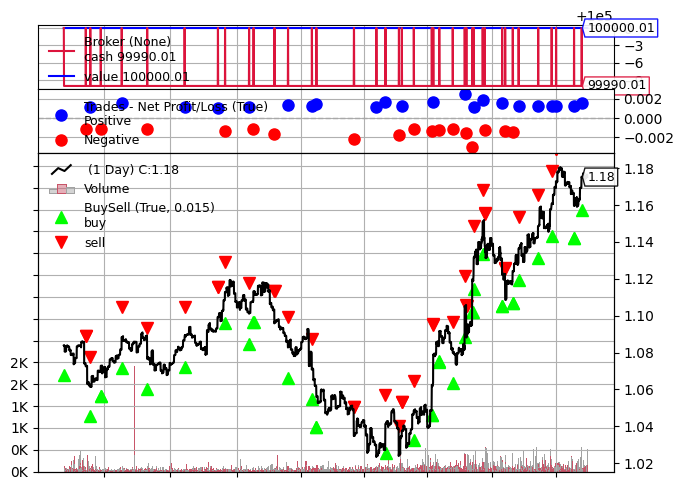

In [163]:

cerebro.plot(
			# width = 100, 
			# height = 50, 
			dpi=500,
			iplot= True,
			)[0][0] # type: ignore

In [164]:
strategy_params = pd.DataFrame(results[0].params.__dict__, index = ['value']).T

with pd.ExcelWriter("stats.xlsx",  engine="openpyxl" , mode='w') as writer:
	strategy_params.to_excel(writer, index =True,sheet_name='strategy settings')
	trade_stats.to_excel(writer, index =True,sheet_name='trade stats') # type: ignore

In [165]:
import json

config = {
    "win_size": window_size,
    "n_feature": env.num_features,

}

with open("config.json", "w") as f:
    json.dump(config, f)


In [166]:
torch.save(agent.policy.state_dict(), f"saved-trade-model.pt")

# Hint: 
	for Loading model

In [167]:
# import json
# from .Policy_Network_Structure import PolicyNetwork


# with open("config.json", "r") as f:
#     config = json.load(f)
    

# print(config)
# # -------------------------

# policy = PolicyNetwork(**config)
# policy_dict = torch.load(r'C:\Users\Nemo\Desktop\sth-financial\model-for-test\trade-model 75.0.pt', weights_only=True,map_location=torch.device('cpu'))
# policy.load_state_dict(policy_dict)
# policy.eval()